In [11]:
from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem
from train_valid_test_loader import load_train_valid_test_datasets
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
    load_train_valid_test_datasets()

In [18]:
alpha = 0.0
K_values = [2, 10, 50]
# K_values = [2]

models_by_K = {}

n_epochs = 600
batch_size=1000

for K in K_values:
    print(f"==================K={K}===========")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs, batch_size=batch_size, step_size=0.1,
        n_factors=K, alpha=alpha)
    model.init_parameter_dict(n_users, n_items, train_tuple)
    model.fit(train_tuple, valid_tuple)
    
    # print(f"model.trace_loss: {model.trace_loss}")
    # print(f"model.trace_epoch: {model.trace_epoch}")
    # print(f"model.trace_auc_train: {model.trace_auc_train}")
    # print(f"model.trace_auc_valid: {model.trace_auc_valid}")
    
    models_by_K[K] = model

==================K=2===========
epoch       0.000 | loss_total     1.56001 | train_AUC    0.50269 | valid_AUC     0.49616 | grad_wrt_mu     0.95200 | grad_wrt_b_per_user     0.00167 | grad_wrt_c_per_item     0.00104 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.014 | loss_total     1.42678 | train_AUC    0.63281 | valid_AUC     0.61651 | grad_wrt_mu     0.90688 | grad_wrt_b_per_user     0.00164 | grad_wrt_c_per_item     0.00092 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.029 | loss_total     1.45327 | train_AUC    0.65425 | valid_AUC     0.64060 | grad_wrt_mu     0.86868 | grad_wrt_b_per_user     0.00163 | grad_wrt_c_per_item     0.00101 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.043 | loss_total     1.35080 | train_AUC    0.67568 | valid_AUC     0.65982 | grad_wrt_mu     0.50862 | grad_wrt_b_per_user     0.00148 | grad_wrt_c_per_item     0.00093 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.129 | loss_total 

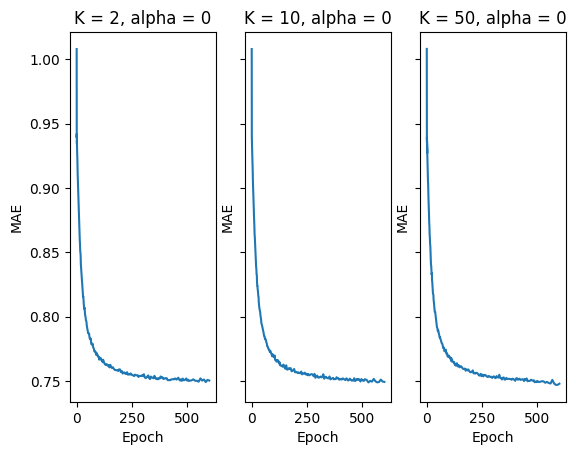

In [32]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)

for i, K in enumerate(K_values):
    model = models_by_K[K]
    a = ax[i]
    a.set_title(f"K = {K}, alpha = 0")
    a.set_ylabel("MAE")
    a.set_xlabel("Epoch")
    a.plot(model.trace_epoch, model.trace_mae_valid)

In [73]:

best_0_alpha_model = min(models_by_K.values(), key=lambda m: m.trace_mae_valid[-1])
print("best K:", best_0_alpha_model.n_factors)

best K: 50


In [57]:
alpha_values = [0.01, 0.1, 0.3, 0.5, 0.8]

mae_by_alpha = {}
models_by_alpha = {}
for alpha in alpha_values:
    alpha_svd = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs, batch_size=batch_size, step_size=0.1,
        n_factors=50, alpha=alpha
    )
    alpha_svd.init_parameter_dict(n_users, n_items, train_tuple)
    alpha_svd.fit(train_tuple, valid_tuple)
    models_by_alpha[alpha] = alpha_svd

    

epoch       0.000 | loss_total     1.52105 | train_AUC    0.50235 | valid_AUC     0.50524 | grad_wrt_mu     0.93399 | grad_wrt_b_per_user     0.00163 | grad_wrt_c_per_item     0.00095 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.014 | loss_total     1.42401 | train_AUC    0.57969 | valid_AUC     0.57697 | grad_wrt_mu     0.84035 | grad_wrt_b_per_user     0.00164 | grad_wrt_c_per_item     0.00097 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.029 | loss_total     1.34875 | train_AUC    0.62381 | valid_AUC     0.62297 | grad_wrt_mu     0.66193 | grad_wrt_b_per_user     0.00154 | grad_wrt_c_per_item     0.00094 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.043 | loss_total     1.43474 | train_AUC    0.64720 | valid_AUC     0.64361 | grad_wrt_mu     0.69270 | grad_wrt_b_per_user     0.00156 | grad_wrt_c_per_item     0.00095 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.129 | loss_total     1.17916 | train_AUC    0.7077

In [65]:
for model in models_by_alpha.values():
    print(f"{model.alpha}: {model.trace_mae_valid[-1]}")
    
best_alpha_model = min(models_by_alpha.values(), key=lambda m: m.trace_mae_valid[-1])
print("best model alpha:", best_alpha_model.alpha)

0.01: 0.7491809425196387
0.1: 0.7605923155291546
0.3: 0.7748879142540643
0.5: 0.7858217991385261
0.8: 0.8017489004814982
best model alpha: 0.01


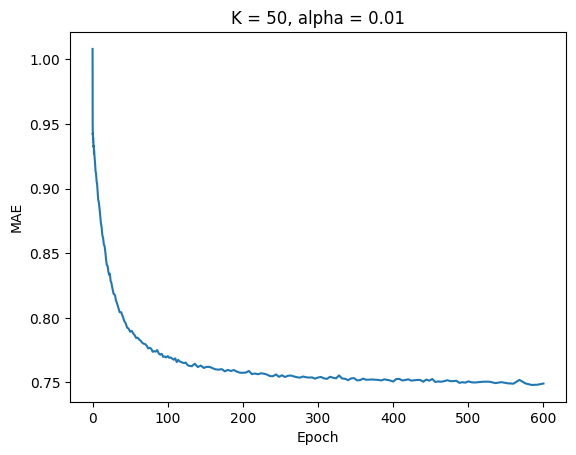

In [67]:
mae_by_epoch = best_alpha_model.trace_mae_valid
ax = plt.axes()
ax.set_title(f"K = {K}, alpha = {best_alpha_model.alpha}")
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
ax.plot(best_alpha_model.trace_epoch, best_alpha_model.trace_mae_valid)

In [75]:
import pandas as pd
select_movies_df = pd.read_csv("./data_movie_lens_100k/select_movies.csv")
movie_ids = np.array(select_movies_df["item_id"])
print("movie IDs:", movie_ids)
user_ids = valid_tuple[0]
yhat_N = best_0_alpha_model.predict(user_ids, movie_ids, **best_0_alpha_model.param_dict)
print(yhat_N)

movie IDs: [  0  70  98 131 142  49 171 180  81 251 173 209  65  87 254  90 199 218
 286 893]


ValueError: operands could not be broadcast together with shapes (9992,50) (20,50) 